In [6]:
!git clone https://github.com/c-bun/NanoBiT-BRET.git

fatal: destination path 'NanoBiT-BRET' already exists and is not an empty directory.


In [14]:
import pandas as pd
#from google.colab import drive
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import numpy as np
from scipy.optimize import curve_fit
#drive.mount('/content/gdrive')

In [8]:
file_path = '/content/NanoBiT-BRET/BRET efficiencies/TMR gly linkers spectra.xlsx'
df = pd.read_excel(file_path)
df = df.melt(id_vars=['Peptide', 'Wavelength'], var_name='Trial', value_name='Luminescence')

In [9]:
# set the dtype for D5 and Wavel. to int64
df['Luminescence'] = df['Luminescence'].astype('int64')
df['Wavelength'] = df['Wavelength'].astype('int64')

<Axes: xlabel='Wavelength', ylabel='Luminescence'>

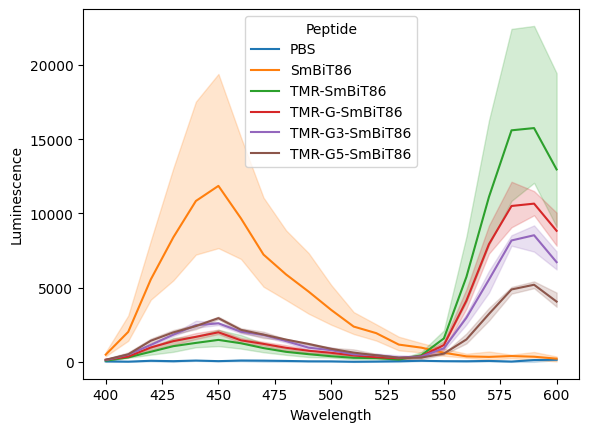

In [10]:
sns.lineplot(data=df, x='Wavelength', y='Luminescence', hue='Peptide')

In [17]:
def extrapolate(df, x_col, y_col, start=-2, stop=None):
  df[y_col] = df[y_col].astype('float64')
  df[x_col] = df[x_col].astype('float64')

  # extrapolate the final point
  y = df[y_col][start:stop].values
  x = df[x_col][start:stop].values
  print(x,y)
  m, b = np.polyfit(x, y, 1)

  # find the x intercept
  x_intercept = -b/m
  extrap_y = m*x_intercept + b

  x = np.append(df[x_col].values, x_intercept)
  y = np.append(df[y_col].values, extrap_y)

  return x, y

def trapezoidal_int(x, y, cutoff):
  all = integrate.trapezoid(y, x)
  lgbit = integrate.trapezoid(y[:cutoff], x[:cutoff])
  bret = integrate.trapezoid(y[cutoff:], x[cutoff:])
  efficiency = bret/all
  print("Total: ",all)
  print("LG-bit: ",lgbit)
  print("BRET: ",bret)
  print("Efficiency: ",efficiency)
  return all, lgbit, bret, efficiency

def gaussian(x, a, emission_max, width):
    return a * np.exp(-((x - emission_max)**2) / (2 * width**2))

def boltzmann(w, w_plus, w_minus, w_max, I_max):
  # from https://onlinelibrary.wiley.com/doi/abs/10.1111/j.1751-1097.1996.tb02464.x
  # this does not currently work.
  v = 1/w
  v_plus = 1/w_plus
  v_minus = 1/w_minus
  v_max = 1/w_max
  H = v_plus - v_minus
  rho = (v_max - v_minus)/(v_plus - v_max)
  a = v_max + H*rho/(rho**2 - 1)
  I = I_max * np.exp(-(np.log(2)/np.log(rho)**2) * np.log((a - v)/(a - v_max))**2)
  # still need to implement. some of the math symbols are weird
  # if v < a:
  #   return I
  # else:
  #   return 0
  return np.where(v < a, I, 0)

def extrapolate_gaussian(df, x_col, y_col, cutoff, function=gaussian):
  # Drop rows with NaN in the y_col before converting to numpy arrays
  df = df.dropna(subset=[y_col]).copy()

  y_col = df[y_col].astype('float64').values
  x_col = df[x_col].astype('float64').values
  cutoff = list(x_col).index(cutoff)

  # fit to gaussian
  print("Fitting x,y: ",x_col[cutoff:], y_col[cutoff:])
  popt, pcov = curve_fit(function, x_col[cutoff:], y_col[cutoff:],
                         p0=[20000, 400, 50], # for gaussian
                         bounds=([1000, 100, 1], [100000, 1000, 500]), # for gaussian
                         #p0=[10, 10, 550, 1], # for boltzmann
                         #bounds=([1, 1, 1, 0.1], [100, 100, 1000, 1]), # for boltzmann
                         )
  #a, emission_max, width = popt
  print("Found params: ", popt)

  # add 20 more datapoints (100 nm worth)
  x_extrap = np.linspace(x_col[-1]+5, x_col[-1]+105, 20)
  y_extrap = function(x_extrap, *popt)

  x = np.append(x_col, x_extrap)
  y = np.append(y_col, y_extrap)

  return x, y, popt

PBS Trial 1
Fitting x,y:  [530. 540. 550. 560. 570. 580. 590. 600.] [134. 129.  37.  47. 114.  48. 188. 120.]
Found params:  [1000.          100.00000001  214.8567095 ]
Total:  21843.683297651212
LG-bit:  10745.0
BRET:  9783.683297651212
Efficiency:  0.44789530979435244
PBS Trial 2
Fitting x,y:  [530. 540. 550. 560. 570. 580. 590. 600.] [  8.  56.  37.  81.  31.  26.   6. 155.]
Found params:  [1000.00000004  100.00000001  184.39979497]
Total:  8653.700901300963
LG-bit:  3835.0
BRET:  4498.700901300963
Efficiency:  0.5198586076189259
PBS Trial 3
Fitting x,y:  [530. 540. 550. 560. 570. 580. 590. 600.] [  3.  54.  80.  12.  61.   7. 189. 177.]
Found params:  [1000.00000002  100.          195.95166907]
Total:  14104.277834336535
LG-bit:  6690.0
BRET:  7129.277834336535
Efficiency:  0.5054691858792284
SmBiT86 Trial 1
Fitting x,y:  [530. 540. 550. 560. 570. 580. 590. 600.] [1026.  641.  552.  293.  163.  253.  143.  261.]
Found params:  [1.00000000e+05 2.28008171e+02 9.91809666e+01]
Total:  

,Peptide,Trial,Total,LG-bit,BRET,Efficiency
0,PBS,Trial 1,2.184368e+04,10745.0,9.783683e+03,0.447895
1,PBS,Trial 2,8.653701e+03,3835.0,4.498701e+03,0.519859
2,PBS,Trial 3,1.410428e+04,6690.0,7.129278e+03,0.505469
3,SmBiT86,Trial 1,5.878833e+05,558385.0,2.116327e+04,0.035999
4,SmBiT86,Trial 2,5.608557e+05,528370.0,2.371065e+04,0.042276
5,SmBiT86,Trial 3,1.226633e+06,1158990.0,5.278291e+04,0.043031
6,TMR-SmBiT86,Trial 1,6.847944e+05,80215.0,6.023544e+05,0.879614
7,TMR-SmBiT86,Trial 2,6.001364e+05,68720.0,5.287314e+05,0.881019
8,TMR-SmBiT86,Trial 3,1.229222e+06,129155.0,1.095787e+06,0.891448
9,TMR-G-SmBiT86,Trial 1,5.774698e+05,111295.0,4.632798e+05,0.802258


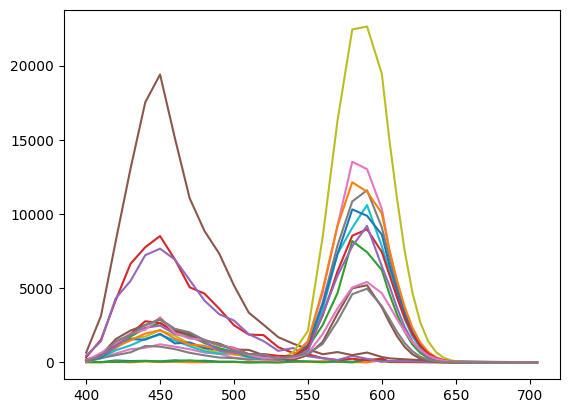

In [22]:
d = {
    'Peptide': [],
    'Trial': [],
    'Total': [],
    'LG-bit': [],
    'BRET': [],
    'Efficiency': []
}
for peptide in df['Peptide'].unique():
  for trial in df['Trial'].unique():
    print(peptide, trial)
    df_temp = df[(df['Peptide'] == peptide) & (df['Trial'] == trial)]
    #x, y = extrapolate(df_temp, 'Wavelength', 'Luminescence')
    x, y, popt = extrapolate_gaussian(df_temp, 'Wavelength', 'Luminescence', cutoff=530)
    sns.lineplot(x=x, y=y)
    all, lgbit, bret, efficiency = trapezoidal_int(x, y, 14)
    d['Peptide'].append(peptide)
    d['Trial'].append(trial)
    d['Total'].append(all)
    d['LG-bit'].append(lgbit)
    d['BRET'].append(bret)
    d['Efficiency'].append(efficiency)

brets = pd.DataFrame(d)
brets

In [20]:
# find the means across trials
brets_mean = brets.groupby('Peptide').mean(numeric_only=True)
brets_mean

,Total,LG-bit,BRET,Efficiency
Peptide,,,,
PBS,14867.220678,7090.000000,7137.220678,0.491074
SmBiT86,791790.609495,748581.666667,32552.276162,0.040435
TMR-G-SmBiT86,639714.612801,123670.000000,512899.612801,0.801417
TMR-G3-SmBiT86,560915.284252,167426.666667,390156.950918,0.695120
TMR-G5-SmBiT86,416509.236540,181976.666667,231612.569873,0.554689
TMR-SmBiT86,838051.062686,92696.666667,742291.062686,0.884027


In [21]:
df[df['Wavelength']==590].groupby('Peptide').mean(numeric_only=True)

,Wavelength,Luminescence
Peptide,,
PBS,590.0,127.666667
SmBiT86,590.0,352.000000
TMR-G-SmBiT86,590.0,10661.666667
TMR-G3-SmBiT86,590.0,8532.666667
TMR-G5-SmBiT86,590.0,5199.000000
TMR-SmBiT86,590.0,15749.666667
